### Process datafiles, 05.11


In [23]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [11]:
import numpy as np
#import cv2
framerate = 29.18
from scipy import signal
from scipy.signal import argrelextrema

import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
framerate = 29.18


from matplotlib import rc
import matplotlib
#plt.switch_backend('agg')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.unicode']=True


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


Preprocessing functions, for filtering out obvious outliers

In [2]:
def filterOnce(original):
    filtered = original.copy()
    avg = np.average(original)
    std = np.std(original)

    divs = np.abs(original-avg)> 2.5*std
    index = np.arange(0, len(original), 1)
    filtered[index[divs]] = filtered[index[divs]-1]
    #print(np.sum(divs))
    return filtered

def filterUntilSmooth(original):
    filtered = original.copy()
    avg = np.average(original)
    std = np.std(original)
    div = np.abs(original-avg) > 2.5*std
    while(np.sum(div)>0):
        filtered = filterOnce(filtered)
        avg = np.average(filtered)
        std = np.std(filtered)
        div = np.abs(filtered-avg)>2.5*std
    return filtered

def normalize(timeseries):
    avg = np.average(timeseries)
    stdev = np.std(np.abs(timeseries))
    return (timeseries-avg)/stdev


def lin(x, a,b):
    return x*a+b

def drawLine(position, height, width, ax):
    left = [position-width/2.,position + width/2.]
    right = [height,height]
    ax.plot(left, right, '-', c='Crimson', linewidth=2.)
    
def getMaxFourierComponent(x, diag=None, ax = None):## 2 dimensional data, 1st col is time
    dt = x[:,0][1] - x[:,0][0]
    np_fft = np.fft.fft(x[:,1]-np.average(x[:,1]))
    n_samples = len(x)
    T = dt*n_samples
    df = 1./T
    amplitudes = 2./n_samples * np.abs(np_fft) 
    frequencies = np.fft.fftfreq(n_samples) * n_samples*df
    peaks, _ = find_peaks(amplitudes[:len(np_fft)//2], height = np.max(amplitudes)/2.)
    results_half = peak_widths(amplitudes[:len(np_fft)//2], peaks, rel_height=0.5)
    if(diag):
        ax.plot(frequencies[:len(frequencies)//2], amplitudes[:len(np_fft)//2], '-o')
        ax.plot(frequencies[:len(frequencies)//2][peaks], amplitudes[:len(np_fft)//2][peaks], "x", c='black', markersize=10)
        ax.set_xlim(0.05, 0.35)
        ax.set_title(diag)
        drawLine(frequencies[:len(frequencies)//2][peaks[0]], amplitudes[:len(frequencies)//2][peaks[0]]/2., results_half[0][0]*df, ax)
        ax.text(0.05, 0.7*np.max(amplitudes), r"Max Amplitude at %s Hz, Width = %s Hz" %(round(frequencies[:len(frequencies)//2][peaks[0]],3), round(results_half[0][0]*df,3)))
    return [frequencies[:len(frequencies)//2][peaks[0]], results_half[0][0]*df]


### Read measurements with const driving:

In [81]:
freqsold = []
amplold = []
iwold = []
err = []
for e in FixvoltageOldTEST.values():
    freqsold.append(e['freq'])
    amplold.append(e['interfacePos'])
    iwold.append(e['interfaceWidth'])
    err.append(e['error'])

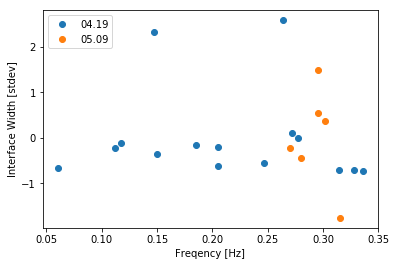

In [53]:
plt.plot(freqsold, normalize(iwold), 'o', label='04.19')
plt.plot(freqs,normalize(iw), 'o', label='05.09')
plt.xlabel('Freqency [Hz]')
plt.ylabel('Interface Width [stdev]')
plt.legend(loc='upper left')
plt.savefig('iwdth_frozen.png', bbox_inches='tight')


# Frequency of the driving

Maximal frequency component of the driving's FT.

Error ~ width at half max of the peak

### Measuremens of 04.19

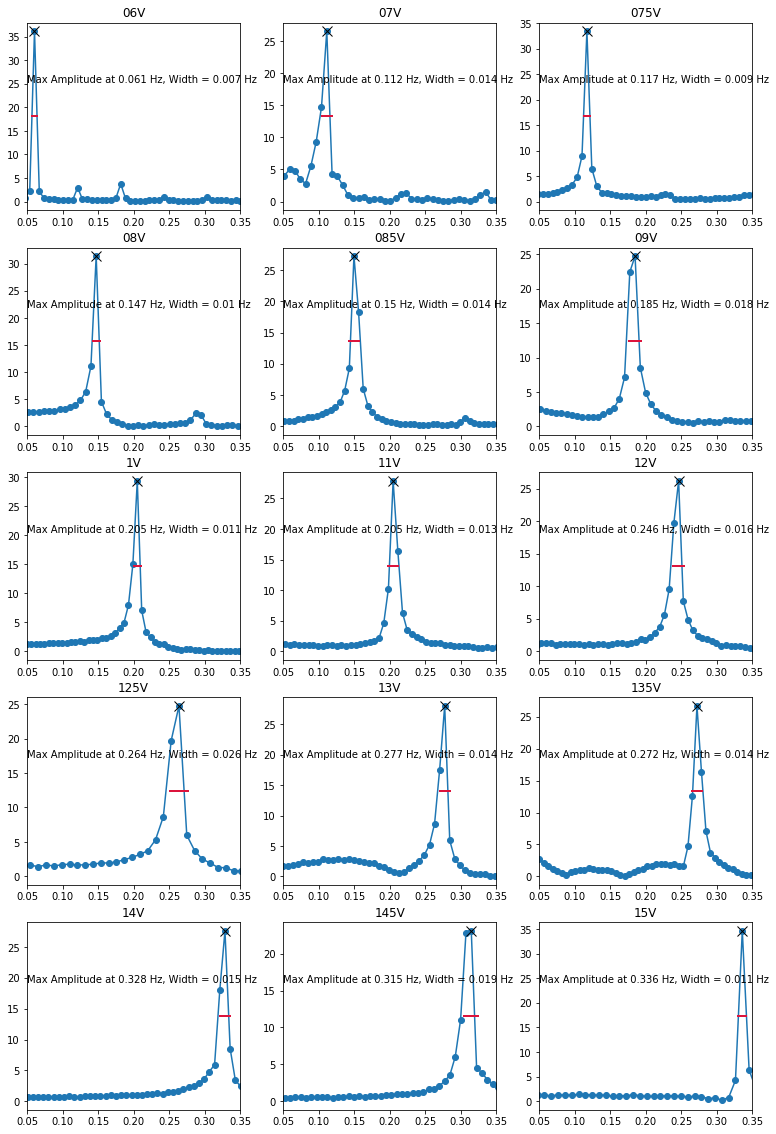

In [4]:
noRampVids = ['06V', '07V', '075V', '08V', '085V', '09V', '1V' , '11V', '12V', '125V', '13V', '135V', '14V', '145V', '15V']

FixvoltageOld = {}

voltages = [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1., 1.1, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]
## diagnostics:
f, axes = plt.subplots(5, 3, figsize=(13,20))
axeslist = axes.flatten()
for i,e in enumerate(noRampVids):
    dictionary = {}
    driving = np.loadtxt('data0419/timeseries/driving/%s' %e, skiprows=2)
    surface = np.loadtxt('data0419/timeseries/surfaceresponse/%s' %e, skiprows=2)
    dictionary['surface'] = surface
    fr, err = getMaxFourierComponent(driving, diag = e, ax = axeslist[i])
    dictionary['freq'] = fr
    dictionary['error'] = err
    dictionary['voltage'] = voltages[i]
    FixvoltageOld[e] = {}
    FixvoltageOld[e]['driving']  = dictionary

    

### Measurements of 05.09

<Figure size 432x288 with 0 Axes>

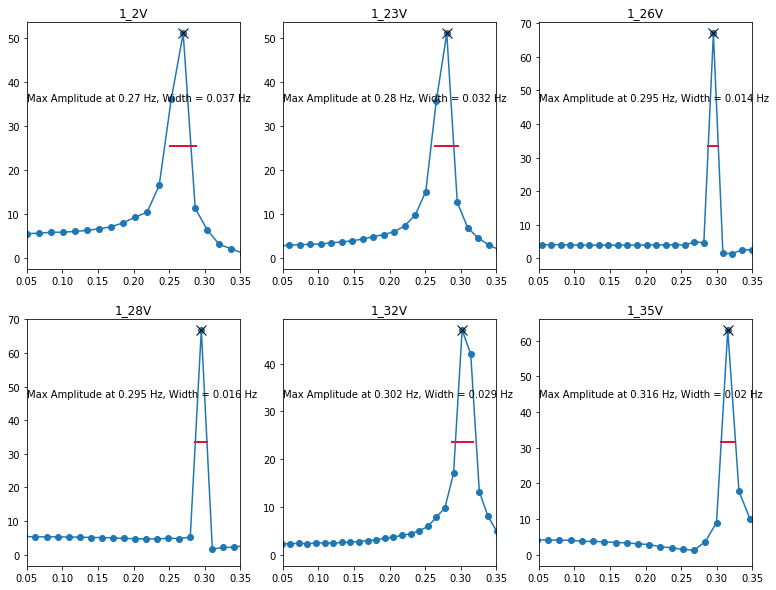

In [5]:
Fixvoltage = {}

voltages = [1.2, 1.23, 1.26, 1.28, 1.32, 1.35]
videos = ['1_2V', '1_23V', '1_26V', '1_28V', '1_32V', '1_35V']
## diagnostics:
plt.clf()
f, axes = plt.subplots(2, 3, figsize=(13,10))
axeslist = axes.flatten()
for i,e in enumerate(videos):
    dictionary = {}
    driving = np.loadtxt('data0509/2/driving/%s' %e, skiprows=2)
    surface = np.loadtxt('data0509/2/surface/%s' %e, skiprows=2)
    dictionary['surface'] = surface
    fr, err = getMaxFourierComponent(driving, diag = e, ax = axeslist[i])
    dictionary['freq'] = fr
    dictionary['error'] = err
    dictionary['voltage'] = voltages[i]
    Fixvoltage[e] = {}
    Fixvoltage[e]['driving']  = dictionary

    

### Voltage - Frequency characteristic

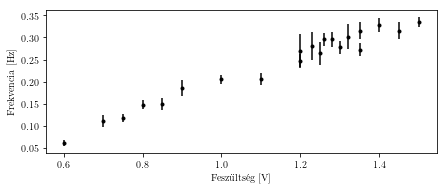

In [13]:
volt1 = []
freqs1 = []
err1 =[]
volt2 = []
freqs2 = []
err2 =[]

for e in FixvoltageOld.values():
    volt1.append(e['driving']['voltage'])
    freqs1.append(e['driving']['freq'])
    err1.append(e['driving']['error'])
for e in Fixvoltage.values():
    volt2.append(e['driving']['voltage'])
    freqs2.append(e['driving']['freq'])
    err2.append(e['driving']['error'])

f = plt.figure()
plt.errorbar(volt1, freqs1, fmt = '.', yerr=err1, label='04.19', c='black')
plt.errorbar(volt2, freqs2, fmt = '.', yerr=err2, label='05.09', c='black')
plt.xlabel('Feszültség [V]')
plt.ylabel('Frekvencia [Hz]')
ratio = 8./6.
f.set_size_inches(3.5*2, 3.5/ratio)
plt.savefig('freq_volt.pdf', bbox_inches='tight')

# Interface displacement and width

- Discard fist 20 seconds
- Interface position is the standard deviation
- Interface width is the mean
- errors: 40 sec moving average, max - min

In [7]:
def slidingStd(x, w):
    result = np.zeros_like(x)
    for index in range(len(x)):
#        print(index)
#        print(w)
#        print(min(w, index))
        windowlength = min(w, index)
        if(index>0):
            view = x[index-windowlength:index]
        else:
            view = x[0]
        result[index] = view.std()
    return result


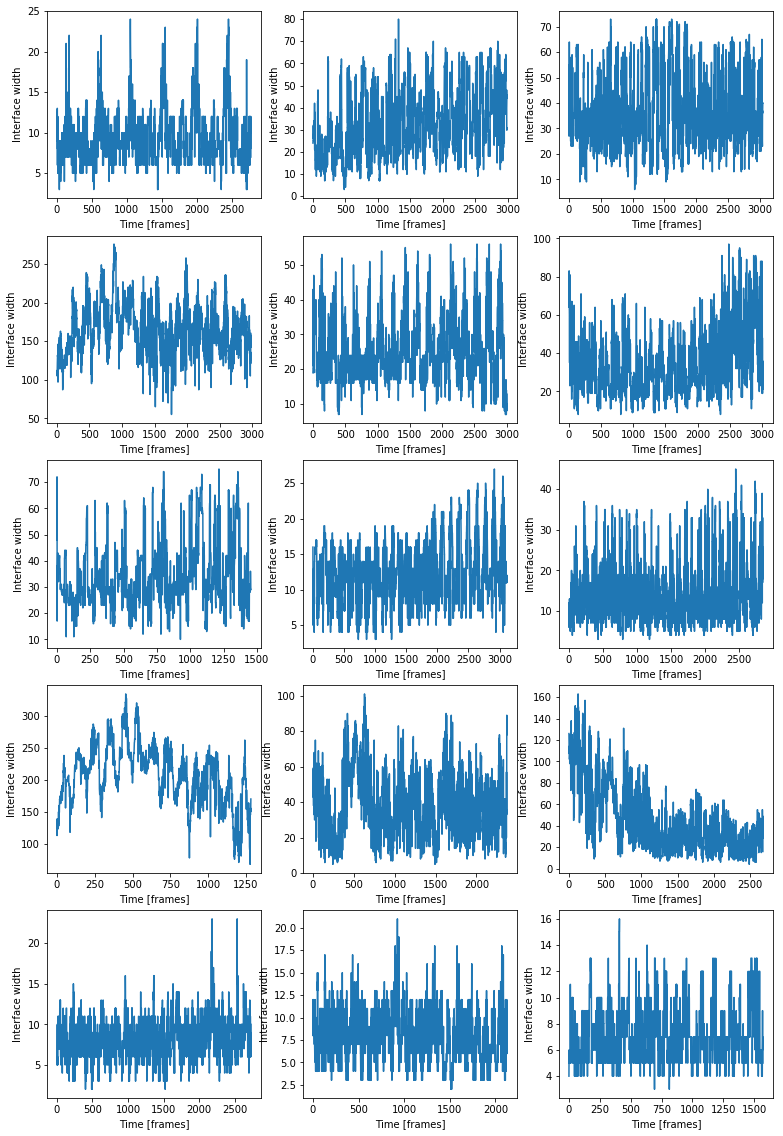

In [10]:
f, axes = plt.subplots(5, 3, figsize=(13,20))
axeslist = axes.flatten()

for i,e in enumerate(noRampVids):
    dictionary= {}
    data = np.loadtxt('data0419/measured/%s.txt' %e)
    dictionary['interfacePosRaw'] = data[:,0]
    dictionary['interfaceWidthRaw'] = data[:,1]
    transient = int(20*framerate)
    dictionary['interfacePos'] = (data[:,0][2*transient:]).std()
    dictionary['interfaceWidth'] = (data[:,1][2*transient:]).mean()
    dictionary['surfacePos'] = (FixvoltageOld[e]['driving']['surface'][:,1]).std()
    N = int(transient)
    ax = axeslist[i]
    amplW = np.convolve(data[:,1][2*transient:], np.ones((N,))/(N), mode='valid')
    slidingWindow = slidingStd(data[:,0][2*transient:], N)[transient:]
    time = 40+np.arange(0., len(amplW), 1)/framerate
    ax.plot( (data[:,1][2*transient:]))
    ax.set_xlabel('Time [frames]')
    ax.set_ylabel('Interface width')
    dictionary['InterfaceWidthError'] = np.max(amplW) - np.min(amplW)
    dictionary['InterfacePosError'] = np.max(slidingWindow) - np.min(slidingWindow)

    FixvoltageOld[e]['interface']  = dictionary


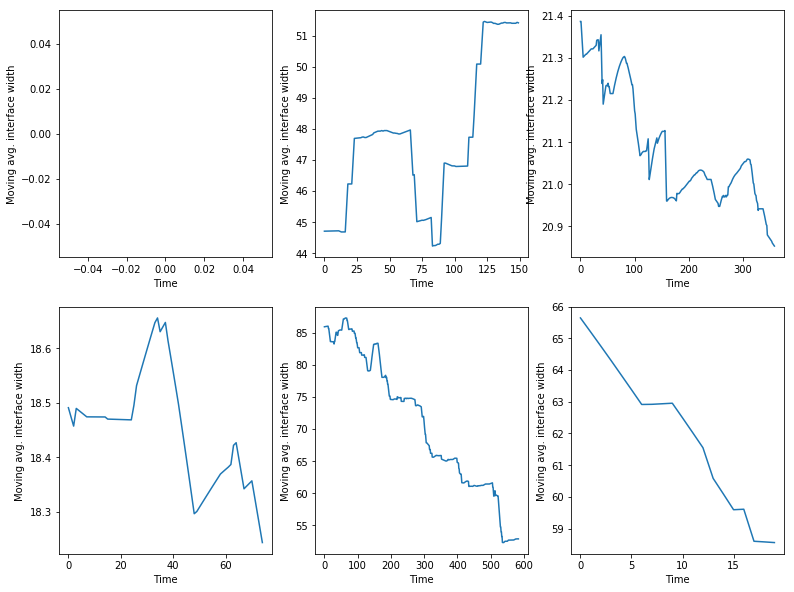

In [58]:
f, axes = plt.subplots(2, 3, figsize=(13,10))
axeslist = axes.flatten()

for i,e in enumerate(videos):
    dictionary= {}
    data = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0509/2/%s' %e)
    dictionary['interfacePosRaw'] = data[:,0]
    dictionary['interfaceWidthRaw'] = data[:,1]
    transient = int(20*framerate)
    dictionary['interfacePos'] = (data[:,0][transient:]).std()
    dictionary['interfaceWidth'] = (data[:,1][transient:]).mean()
    dictionary['surfacePos'] = (Fixvoltage[e]['driving']['surface'][:,1]).std()
    slidingWindow = slidingStd(data[:,0][2*transient:], N)[transient:]

    N = int(transient)
    ax = axeslist[i]
    amplW = np.convolve(data[:,1][transient:], np.ones((N,))/N, mode='valid')
    time = 40+np.arange(0., len(amplW), 1)/framerate
    ax.plot(slidingWindow)
    ax.set_xlabel('Time')
    ax.set_ylabel('Moving avg. interface width')
    dictionary['InterfaceWidthError'] = np.max(amplW) - np.min(amplW)
    #dictionary['InterfacePosError'] = np.max(slidingWindow) - np.min(slidingWindow)

    Fixvoltage[e]['interface']  = dictionary


Text(0.5,0,'Frequency [Hz]')

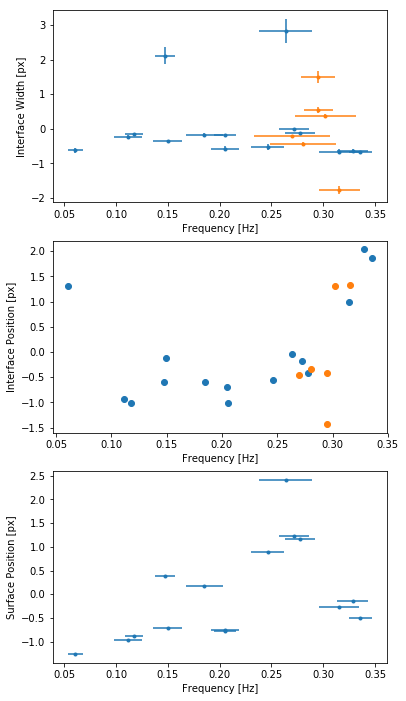

In [64]:
interface1 = []
interface2 = []
surface1 = []
surface2 = []
erriw1 = []
erriw2 = []

for e in FixvoltageOld.values():
    interface1.append([e['interface']['interfaceWidth'], e['interface']['interfacePos']])
    surface1.append(e['interface']['surfacePos'])

    erriw1.append(e['interface']['InterfaceWidthError'])
for e in Fixvoltage.values():
    interface2.append([e['interface']['interfaceWidth'], e['interface']['interfacePos']])
    surface2.append(e['interface']['surfacePos'])
    erriw2.append(e['interface']['InterfaceWidthError'])

interface1 = np.array(interface1)
interface2 = np.array(interface2)
surface1 = np.array(surface1)
surface2 = np.array(surface2)
erriw1 = np.array(erriw1)
erriw2 = np.array(erriw2)
relerr1 = erriw1*0.5 / interface1[:,0]
relerr2 = erriw2*0.5 / interface2[:,0]
err1 = np.array(err1)
err2 = np.array(err2)

f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6, 12))
ax1.errorbar(freqs1, normalize(interface1[:,0]), fmt = '.', xerr = err1, yerr=relerr1*normalize(interface1[:,0]), label='04.19')
ax1.errorbar(freqs2, normalize(interface2[:,0]), fmt = '.', xerr = err2, yerr=relerr2*normalize(interface2[:,0]), label='05.09')
ax1.set_ylabel('Interface Width [px]')
ax1.set_xlabel('Frequency [Hz]')

ax2.plot(freqs1, normalize(interface1[:,1]), 'o')#, fmt = '.', xerr = err1, yerr=relerr1*(interface1[:,1]), label='04.19')
ax2.plot(freqs2, normalize(interface2[:,1]), 'o')#, fmt = '.', xerr = err2, yerr=relerr2*(interface2[:,1]), label='05.09')
ax2.set_ylabel('Interface Position [px]')
ax2.set_xlabel('Frequency [Hz]')

ax3.errorbar(freqs1, normalize(surface1), fmt = '.', xerr = err1,  label='04.19')
#ax3.errorbar(freqs2, normalize(surface2), fmt = '.', xerr = err2,  label='05.09')
ax3.set_ylabel('Surface Position [px]')
ax3.set_xlabel('Frequency [Hz]')

In [38]:
surface1

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

In [65]:
#### FREQS WIDTH XERR YERR INTERFACEPOS SURFACEPOS:
out = np.zeros((len(freqs1), 6))
out[:,0] = freqs1
out[:,1] = normalize(interface1[:,0])
out[:,2] = err1
out[:,3] = relerr1*normalize(interface1[:,0])
out[:,4] = normalize(interface1[:,1])
out[:,5] = normalize(surface1)
out2 = np.zeros((len(freqs2), 6))
out2[:,0] = freqs2
out2[:,1] = normalize(interface2[:,0])
out2[:,2] = err2
out2[:,3] = relerr2*normalize(interface2[:,0])
out2[:,4] = normalize(interface2[:,1])
out2[:,5] = normalize(surface2)

In [66]:
np.savetxt('C:/Users/balin/Docs/boSchlieren/data0509/0419_frozenFreqs.dat', out)
np.savetxt('C:/Users/balin/Docs/boSchlieren/data0509/0509_frozenFreqs.dat', out2)


### 3 layer formula 

In [16]:
d = [51.7, 51.7, 51.6, 51.1, 50.4, 49.1, 48.8, 45.0, 33.4, 25.3, 9.14, 1.2, 0.9, 0.6, 0.5, 0.5, 0.5]
densities29 = [52.0, 51.8, 51.9, 51.2, 50.9, 50.6, 50.2, 33.3, 13., 9., 0.7, 0.8, 0.7, 0.6, 0.5, 0.1, 0.1]
densities29_2 = [52.4, 52.7, 52.6, 52.2, 52.0, 51.6, 50.8, 37.1, 13., 2., 1., 0.8, 0.7, 0.6, 0.5, 0.4, 0.1]
def cond_dens(x):
    return x**4*0.0000000000922584+x**3*(-0.0000000294733)+x**2*0.00000419348+x*0.000322098+0.999075
den = np.array(densities29)


In [52]:
def bouyantFrq(deriv, rho0):
    return np.sqrt(np.abs((9.81*deriv)/rho0))

In [58]:
h3 = 0.065
h1 = 0.065
h2 = 0.03
k = np.pi/(0.255)

In [59]:
drho3 =popt[0]

In [60]:
def K_i(x, N):
    return np.sqrt(np.array(N**2/x**2 - k**2))
T1 = k/np.tanh(h1*k)
T3 = k/np.tanh(h2*k)
def T_i(x, h, N):
    return K_i(x, N)/np.tan(K_i(x, N)*h)
def lhs(x):
    N2 = bouyantFrq(drho3, 1000.)
    return K_i(x, N2)**2 - T1*T_i(x, h2, N2) + T1*T3 -T3*T_i(x, h2, N2) 

In [61]:
from scipy import optimize
root = optimize.newton(lhs, 0.1)

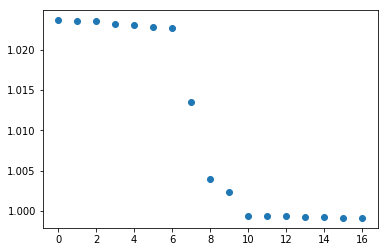

In [62]:
plt.plot(cond_dens(den), 'o')

In [63]:
def lin(x, a, b):
    return a*x + b
from scipy.optimize import curve_fit

In [64]:
x = np.arange(0.07, 0.12, 0.01)
y = 1000*cond_dens(den)[6:11]

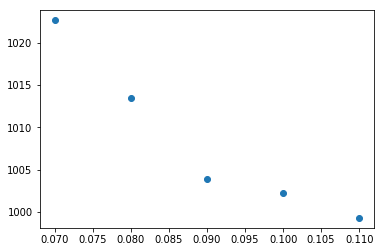

In [65]:
plt.plot(x, y, 'o')

In [66]:
popt, pcov = curve_fit(lin, x, y)

In [67]:
popt

array([-579.17196902, 1060.45538283])

## Resonance frequency from 
$$ 2d = \frac{c}{f}$$

In [68]:
res = root/(2*0.255)
print(res)

0.15764826161978973


In [69]:
def markXaxis(ax, Xpos):
    xmin, xmax = ax.get_xlim()
    xfrac = Xpos / (xmax-xmin)
    ax.annotate('', xy = (xfrac, 0), xytext=(xfrac, -0.1), xycoords = 'axes fraction', arrowprops=dict(facecolor='crimson', shrink=0.05))

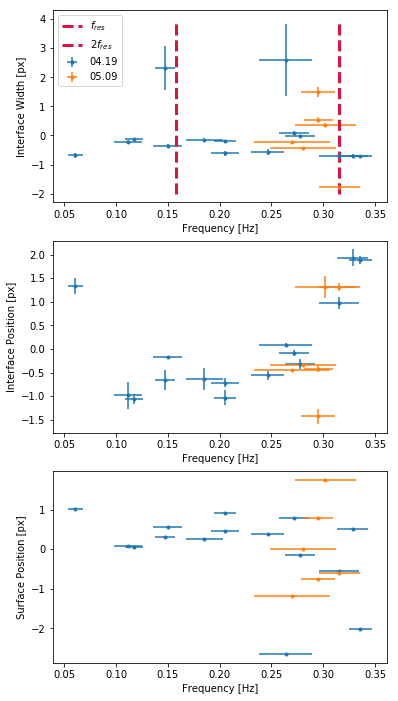

In [72]:

f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6, 12))
ax1.errorbar(freqs1, normalize(interface1[:,0]), fmt = '.', xerr = err1, yerr=relerr1*normalize(interface1[:,0]), label='04.19')
ax1.errorbar(freqs2, normalize(interface2[:,0]), fmt = '.', xerr = err2, yerr=relerr2*normalize(interface2[:,0]), label='05.09')
ax1.set_ylabel('Interface Width [px]')
ax1.set_xlabel('Frequency [Hz]')

ax2.errorbar(freqs1, normalize(interface1[:,1]), fmt = '.', xerr = err1, yerr=relerr1*normalize(interface1[:,1]), label='04.19')
ax2.errorbar(freqs2, normalize(interface2[:,1]), fmt = '.', xerr = err2, yerr=relerr2*normalize(interface2[:,1]), label='05.09')
ax2.set_ylabel('Interface Position [px]')
ax2.set_xlabel('Frequency [Hz]')

ax3.errorbar(freqs1, normalize(surface1), fmt = '.', xerr = err1,  label='04.19')
ax3.errorbar(freqs2, normalize(surface2), fmt = '.', xerr = err2,  label='05.09')
ax3.set_ylabel('Surface Position [px]')
ax3.set_xlabel('Frequency [Hz]')
ax1.plot([res, res], [-2, 4], '--', linewidth = 3., c='Crimson', label='$f_{res}$')
ax1.plot([2*res, 2*res], [-2, 4], '--', linewidth = 3., c='Crimson', label='$2f_{res}$')
ax1.legend(loc='upper left')


### Felszíni tólengés módus

In [67]:
1./(2*2.26/(np.sqrt(9.81*0.16)))

0.27717627899762526

## Figure:


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


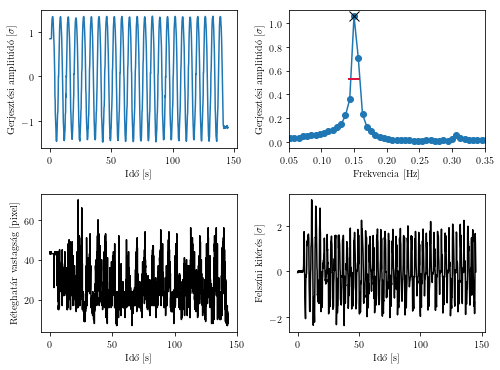

In [12]:
e = '085V'
fig, axes = plt.subplots(2, 2)
driving = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/timeseries/driving/%s' %e, skiprows=2)
surface = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/timeseries/surfaceresponse/%s' %e, skiprows=2)
axes[0,0].plot(driving[:,0], normalize(driving[:,1]), '-')
axes[1,1].plot(surface[:,0], normalize(surface[:,1]), '-', c='black')
x = driving
dt = x[:,0][1] - x[:,0][0]
np_fft = np.fft.fft(normalize(x[:,1]))
n_samples = len(x)
T = dt*n_samples
df = 1./T
amplitudes = 2./n_samples * np.abs(np_fft) 
frequencies = np.fft.fftfreq(n_samples) * n_samples*df
peaks, _ = find_peaks(amplitudes[:len(np_fft)//2], height = np.max(amplitudes)/2.)
results_half = peak_widths(amplitudes[:len(np_fft)//2], peaks, rel_height=0.5)
axes[0,1].plot(frequencies[:len(frequencies)//2], amplitudes[:len(np_fft)//2], '-o')
axes[0,1].plot(frequencies[:len(frequencies)//2][peaks], amplitudes[:len(np_fft)//2][peaks], "x", c='black', markersize=10)
axes[0,1].set_xlim(0.05, 0.35)
drawLine(frequencies[:len(frequencies)//2][peaks[0]], amplitudes[:len(frequencies)//2][peaks[0]]/2., results_half[0][0]*df, axes[0,1])
data = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/measured/%s.txt' %e)
times = np.arange(0., len(data), 1)/29.18
axes[1,0].plot(times, (data[:,1]), c='black')
axes[0,0].set_xlabel('Idő [s]')
axes[1,0].set_xlabel('Idő [s]')
axes[1,1].set_xlabel('Idő [s]')
axes[0,1].set_xlabel('Frekvencia [Hz]')
axes[0,0].set_ylabel('Gerjesztési amplitúdó [$\sigma$]')
axes[0,1].set_ylabel('Gerjesztési amplitúdó [$\sigma$]')
axes[1,0].set_ylabel('Réteghatár vastagság [pixel]')
axes[1,1].set_ylabel('Felszíni kitérés [$\sigma$]')
ratio = 8./6.
fig.set_size_inches(3.5*2, 3.5*2/ratio)
fig.tight_layout()
plt.savefig('timeseries.pdf', bbox_inches='tight')